## 1. Setup and Imports

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from typing import List, Dict, Tuple, Optional

# Import our hybrid transformer
from hybrid_transformer import (
    HybridTransformer,
    scaled_dot_attention,
    CrossAttention,
    GatedSSM,
    count_parameters
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Architecture Overview

**Standard Transformer Components:**

1. **Scaled Dot-Product Attention** :
   $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
   
2. **Causal Self-Attention** :
   - Uses upper-triangular mask to prevent attending to future tokens
   - Essential for autoregressive generation

3. **Positional Encoding** :
   $$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
   $$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

---

### New for RSM Proposal:

#### **Rolling State Memory** $M_t \in \mathbb{R}^{m \times d_m}$

A small matrix of $m$ slots (16-64) that **persists across chunks**:

**Read Operation** (Cross-Attention):
$$C_t = \text{CrossAttn}(Q=H_t, K=M_t, V=M_t)$$
- Tokens query the memory content-addressably
- Retrieves relevant information from past chunks

**Write Operation** (Gated SSM - Proposal Section 2.1, Step 4):
$$M_{t+1} = (1 - G_t) \odot M_t + G_t \odot \phi(AM_t + BU_t)$$

Where:
- $G_t$ = gate (what to write)
- $U_t$ = update signal from tokens (what information to store)
- $A, B$ = learned state-space matrices
- $\phi$ = nonlinearity (tanh)
- $\odot$ = element-wise product

**Key Innovation**: Memory evolves continuously, doesn't reset between chunks!

---

#### **Global Sync Layers** (Proposal Section 2.1, Step 5)

Every $K$ chunks (e.g., K=4):
1. **Tokens → Memory**: Aggregate token representations into memory
2. **Memory → Tokens**: Broadcast memory content back to tokens
3. **Bidirectional consolidation**: Stronger coupling than normal read/write

This prevents memory drift over very long sequences.

## 3. Long Document Dataset

**Goal**: Process a very long document (10k+ tokens) in chunks, testing if the model can:
1. Store facts in memory when first encountered
2. Retrieve them many chunks later (beyond the local window)
3. Maintain constant memory usage regardless of document length

In [10]:
# Load multiple history chapters to create a long document
AMERICAN_REVOLUTION = """
The American Revolution: A Turning Point in History

The American Revolution, which took place between 1775 and 1783, was a pivotal moment in world history. 
The conflict began in April 1775 with the Battles of Lexington and Concord in Massachusetts. 
These initial skirmishes marked the beginning of armed conflict between Great Britain and the thirteen American colonies.

George Washington, a Virginia planter and military veteran, was appointed Commander-in-Chief of the Continental Army 
in June 1775. His leadership would prove crucial to the success of the revolutionary cause. The Continental Congress, 
meeting in Philadelphia, worked to coordinate the colonial resistance efforts.

On July 4, 1776, the Continental Congress adopted the Declaration of Independence, primarily authored by Thomas Jefferson. 
This document, signed in Philadelphia, formally declared the colonies' separation from British rule.
"""

CONSTITUTION_CHAPTER = """
The Constitution and Early Republic

Following the Revolution, the new nation struggled under the Articles of Confederation. In 1787, delegates 
gathered in Philadelphia for the Constitutional Convention. James Madison, often called the Father of the Constitution, 
played a leading role in drafting this foundational document. The Constitution established a federal system with 
three branches of government: executive, legislative, and judicial.

George Washington was elected as the first President in 1789, setting many precedents for the office. His Secretary 
of Treasury, Alexander Hamilton, established the national bank and financial system. Meanwhile, Thomas Jefferson 
served as Secretary of State, often clashing with Hamilton over the scope of federal power.
"""

WAR_OF_1812 = """
The War of 1812

Tensions with Britain escalated again by 1812. President James Madison led the nation into war against Britain, 
fighting over maritime rights and western expansion. The war saw the burning of Washington D.C. in 1814, forcing 
James Madison and his wife Dolley to flee the capital. However, American forces under Andrew Jackson achieved a 
decisive victory at the Battle of New Orleans in January 1815, making Jackson a national hero.

The war concluded with the Treaty of Ghent in 1815, restoring pre-war boundaries. Francis Scott Key wrote the 
Star-Spangled Banner after witnessing the bombardment of Fort McHenry in Baltimore.
"""

# Combine into one long document
LONG_HISTORY_DOCUMENT = AMERICAN_REVOLUTION + "\n\n" + CONSTITUTION_CHAPTER + "\n\n" + WAR_OF_1812

# Key facts distributed throughout the document
KEY_FACTS_DISTRIBUTED = {
    # Early facts (chunk 0-5)
    "early": [
        ("George Washington", "Commander-in-Chief", "mentioned in chunk 0-2"),
        ("July 4, 1776", "Declaration of Independence", "mentioned in chunk 0-2"),
        ("Thomas Jefferson", "authored Declaration", "mentioned in chunk 0-2"),
    ],
    # Middle facts (chunk 10-20)
    "middle": [
        ("James Madison", "Father of Constitution", "mentioned in chunk 10-15"),
        ("1787", "Constitutional Convention", "mentioned in chunk 10-15"),
        ("Alexander Hamilton", "Secretary of Treasury", "mentioned in chunk 10-15"),
    ],
    # Late facts (chunk 25-35)
    "late": [
        ("War of 1812", "James Madison president", "mentioned in chunk 25-30"),
        ("Andrew Jackson", "Battle of New Orleans", "mentioned in chunk 25-30"),
        ("Francis Scott Key", "Star-Spangled Banner", "mentioned in chunk 25-30"),
    ]
}

print(f"Total document length: {len(LONG_HISTORY_DOCUMENT)} characters")
print(f"Approx. words: {len(LONG_HISTORY_DOCUMENT.split())}")
print(f"\nThis will be split into chunks for processing.")

Total document length: 2344 characters
Approx. words: 339

This will be split into chunks for processing.


## 4. Character Tokenization

Same as test1.ipynb - character-level for simplicity.

In [11]:
class CharacterTokenizer:
    """Simple character-level tokenizer."""
    
    def __init__(self, text: str):
        chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i+3 for i, ch in enumerate(chars)}
        self.char_to_idx['<PAD>'] = 0
        self.char_to_idx['<START>'] = 1
        self.char_to_idx['<END>'] = 2
        self.idx_to_char = {i: ch for ch, i in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
    def encode(self, text: str) -> List[int]:
        return [self.char_to_idx.get(ch, 0) for ch in text]
    
    def decode(self, indices: List[int]) -> str:
        return ''.join([self.idx_to_char.get(idx, '<UNK>') for idx in indices])
    
    def __len__(self):
        return self.vocab_size

tokenizer = CharacterTokenizer(LONG_HISTORY_DOCUMENT)
print(f"Vocabulary size: {len(tokenizer)}")

# Encode full document
encoded_document = tokenizer.encode(LONG_HISTORY_DOCUMENT)
print(f"Encoded document length: {len(encoded_document)} tokens")

Vocabulary size: 64
Encoded document length: 2344 tokens


## 5. Chunked Processing Dataset

**Critical for RSM**: Process document in **chunks**, maintain memory **across** chunks.

### Architecture Flow (Proposal Section 2.1):

```
Chunk 0: [tokens] → Local Attn → Read Memory M₀ → Process → Write → M₁
                                      ↓
Chunk 1: [tokens] → Local Attn → Read Memory M₁ → Process → Write → M₂
                                      ↓
Chunk 2: [tokens] → Local Attn → Read Memory M₂ → Process → Write → M₃
   ...
Chunk K: [GLOBAL SYNC: Bidirectional tokens ↔ memory]
   ...
Chunk N: [tokens] → Read Memory Mₙ → Can retrieve facts from Chunk 0!
```

**Memory persists across chunks**, enabling unbounded context.

In [12]:
class ChunkedLongDocumentDataset:
    """
    Dataset that yields chunks of a long document for rolling state memory training.
    
    Unlike standard datasets that return independent samples, this returns
    consecutive chunks from the same document, allowing memory to persist.
    
    Args:
        encoded_text: Full document as list of token IDs
        chunk_size: Size of each chunk (e.g., 256 tokens)
        tokenizer: Tokenizer for decoding
    """
    
    def __init__(self, encoded_text: List[int], chunk_size: int, tokenizer):
        self.encoded_text = encoded_text
        self.chunk_size = chunk_size
        self.tokenizer = tokenizer
        
        # Calculate number of complete chunks
        self.num_chunks = len(encoded_text) // chunk_size
        
    def get_chunk(self, chunk_idx: int):
        """Get a specific chunk by index."""
        start = chunk_idx * self.chunk_size
        end = start + self.chunk_size
        
        chunk = self.encoded_text[start:end]
        
        # For language modeling: input = chunk[:-1], target = chunk[1:]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        
        return x, y
    
    def __len__(self):
        return self.num_chunks

# Create dataset
chunk_size = 256
dataset = ChunkedLongDocumentDataset(encoded_document, chunk_size, tokenizer)

print(f"Document split into {len(dataset)} chunks of {chunk_size} tokens each")
print(f"Total coverage: {len(dataset) * chunk_size} / {len(encoded_document)} tokens")

# Show first chunk
x0, y0 = dataset.get_chunk(0)
print(f"\nChunk 0 preview (first 100 chars):")
print(tokenizer.decode(x0[:100].tolist()))

Document split into 9 chunks of 256 tokens each
Total coverage: 2304 / 2344 tokens

Chunk 0 preview (first 100 chars):

The American Revolution: A Turning Point in History

The American Revolution, which took place betw


## 6. Enhanced Model with Global Sync

**Extension of HybridTransformer** from hybrid_transformer.py:

We add a **GlobalSyncLayer** that implements bidirectional token ↔ memory synchronization.

In [13]:
class GlobalSyncLayer(nn.Module):
    """
    Bidirectional synchronization between tokens and memory.
    
    Implements Proposal Section 2.1, Step 5:
    Every K chunks, perform stronger two-way interaction:
    
    1. Tokens → Memory: Aggregate token information into memory slots
    2. Memory → Tokens: Broadcast memory content back to all tokens
    
    Mathematical formulation:
    
    Tokens → Memory:
        M_sync = M + CrossAttn(Q=M, K=H, V=H)
    
    Memory → Tokens:
        H_sync = H + CrossAttn(Q=H, K=M_sync, V=M_sync)
    
    This prevents memory drift and realigns representations.
    """
    
    def __init__(self, hidden_size: int, n_slots: int):
        super().__init__()
        
        # Memory queries tokens
        self.memory_to_tokens = CrossAttention(hidden_size, n_slots)
        
        # Tokens query memory
        self.tokens_to_memory = CrossAttention(hidden_size, n_slots)
        
        # Layer norms
        self.norm_tokens = nn.LayerNorm(hidden_size)
        self.norm_memory = nn.LayerNorm(hidden_size)
        
    def forward(self, tokens, memory):
        """
        Args:
            tokens: (batch, seq_len, hidden_size)
            memory: (batch, n_slots, hidden_size)
        
        Returns:
            synced_tokens: (batch, seq_len, hidden_size)
            synced_memory: (batch, n_slots, hidden_size)
        """
        # Step 1: Memory reads from tokens (aggregate information)
        # Memory slots attend to all tokens in current chunk
        memory_update = self.memory_to_tokens(self.norm_memory(memory), tokens)
        synced_memory = memory + memory_update
        
        # Step 2: Tokens read from updated memory (broadcast information)
        # Each token attends to all memory slots
        token_update = self.tokens_to_memory(self.norm_tokens(tokens), synced_memory)
        synced_tokens = tokens + token_update
        
        return synced_tokens, synced_memory

print("GlobalSyncLayer defined")

GlobalSyncLayer defined


## 7. Model Setup for RSM

**Configuration from Proposal Section 3 (Practical Recipe)**:
- Local window W: 256 tokens (smaller for faster training)
- Memory slots m: 32 (more than test1.ipynb's 16)
- Global sync cadence K: every 4 chunks
- Hidden size: 128
- Layers: 4

In [14]:
# Model configuration aligned with RSM proposal
config = {
    "vocab_size": len(tokenizer),
    "hidden_size": 128,
    "num_layers": 4,
    "num_heads": 4,
    "num_memory_slots": 32,  # More slots for longer context
    "mlp_ratio": 4,
    "dropout": 0.1,
    "max_seq_length": chunk_size,
}

# Create model
model = HybridTransformer(
    vocab_size=config["vocab_size"],
    hidden_size=config["hidden_size"],
    num_layers=config["num_layers"],
    n_slots=config["num_memory_slots"],
    window_size=config["max_seq_length"]
).to(device)

# Global sync layer (applied every K chunks)
global_sync = GlobalSyncLayer(
    hidden_size=config["hidden_size"],
    n_slots=config["num_memory_slots"]
).to(device)

print(f"Model parameters: {count_parameters(model):,}")
print(f"Sync layer parameters: {count_parameters(global_sync):,}")
print(f"\nMemory slots: {config['num_memory_slots']}")
print(f"Chunk size: {chunk_size} tokens")
print(f"Sync cadence: every 4 chunks")

Model parameters: 736,768
Sync layer parameters: 98,816

Memory slots: 32
Chunk size: 256 tokens
Sync cadence: every 4 chunks


## 8. Chunked Training Loop

**Key Innovation**: Memory persists across chunks!

### Training Algorithm (Proposal Section 2.1):

```python
memory_state = initialize_memory()

for chunk_idx, chunk in enumerate(document_chunks):
    # Step 1-3: Local attention + memory read + fusion
    logits, memory_state = model(chunk, memory_state)
    
    # Step 4: Memory write (SSM update) happens in model
    
    # Step 5: Global sync every K chunks
    if chunk_idx % K == 0:
        tokens, memory_state = global_sync(tokens, memory_state)
    
    loss = cross_entropy(logits, targets)
    loss.backward()  # Truncated BPTT
```

**Truncated BPTT**: Gradients flow within chunk and to memory, but not to previous chunks.

In [15]:
def train_one_pass_through_document(model, global_sync, dataset, optimizer, device, sync_cadence=4):
    """
    Train on one complete pass through the document.
    
    This implements the RSM proposal's core idea:
    - Process document chunk by chunk
    - Memory persists across chunks
    - Global sync every K chunks
    - Truncated BPTT (gradients don't flow across chunks)
    
    Returns:
        metrics: Dict with loss, accuracy, memory evolution
    """
    model.train()
    if global_sync is not None:
        global_sync.train()
    
    # Initialize memory state (batch_size=1 for single document)
    batch_size = 1
    memory_state = model.memory_init.expand(batch_size, -1, -1).detach()
    
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    memory_evolution = []  # Track how memory changes
    
    num_chunks = len(dataset)
    
    for chunk_idx in range(num_chunks):
        # Get chunk
        x, y = dataset.get_chunk(chunk_idx)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y = y.unsqueeze(0).to(device)
        
        # Forward pass with persistent memory
        logits, new_memory_state = model(x, memory_state)
        
        # Global sync every K chunks (Proposal Section 2.1, Step 5)
        if global_sync is not None and chunk_idx % sync_cadence == 0 and chunk_idx > 0:
            # Get token representations from model's last layer
            with torch.no_grad():
                # Extract hidden states (approximate with embeddings for simplicity)
                pos = torch.arange(0, x.size(1), device=device).long()
                token_repr = model.tok_emb(x) + model.pos_emb(pos)
            
            # Bidirectional sync
            _, new_memory_state = global_sync(token_repr, new_memory_state)
        
        # Compute loss
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        
        # Backward (truncated BPTT - only within this chunk)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if global_sync is not None:
            torch.nn.utils.clip_grad_norm_(global_sync.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Detach memory for next chunk (truncated BPTT)
        memory_state = new_memory_state.detach()
        
        # Track metrics
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds == y).sum().item()
        total_tokens += y.numel()
        
        # Save memory snapshot
        if chunk_idx % 5 == 0:
            memory_evolution.append(memory_state.cpu().detach().numpy())
    
    avg_loss = total_loss / num_chunks
    accuracy = total_correct / total_tokens
    
    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        "memory_evolution": memory_evolution
    }

print("Training function defined")

Training function defined


## 9. Train the Model

Train for multiple passes through the document.

In [23]:
# Training setup
num_epochs = 200  # Multiple passes through document
learning_rate = 3e-4

optimizer = torch.optim.AdamW(
    list(model.parameters()) + list(global_sync.parameters()),
    lr=learning_rate
)

history = {"loss": [], "accuracy": []}

print(f"Training for {num_epochs} epochs...")
print(f"Each epoch processes {len(dataset)} chunks\n")

for epoch in range(num_epochs):
    metrics = train_one_pass_through_document(
        model, global_sync, dataset, optimizer, device, sync_cadence=4
    )
    
    history["loss"].append(metrics["loss"])
    history["accuracy"].append(metrics["accuracy"])
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {metrics['loss']:.4f}, Acc: {metrics['accuracy']:.4f}")

print("\nTraining complete!")

Training for 200 epochs...
Each epoch processes 9 chunks

Epoch 5/200 - Loss: 0.9896, Acc: 0.6819
Epoch 10/200 - Loss: 0.9218, Acc: 0.7063
Epoch 15/200 - Loss: 0.7340, Acc: 0.7582
Epoch 20/200 - Loss: 0.5731, Acc: 0.8183
Epoch 25/200 - Loss: 0.4979, Acc: 0.8397
Epoch 30/200 - Loss: 0.3491, Acc: 0.8972
Epoch 35/200 - Loss: 0.2839, Acc: 0.9146
Epoch 40/200 - Loss: 0.2063, Acc: 0.9468
Epoch 45/200 - Loss: 0.1805, Acc: 0.9586
Epoch 50/200 - Loss: 0.1377, Acc: 0.9704
Epoch 55/200 - Loss: 0.1521, Acc: 0.9582
Epoch 60/200 - Loss: 0.1149, Acc: 0.9739
Epoch 65/200 - Loss: 0.1225, Acc: 0.9708
Epoch 70/200 - Loss: 0.0784, Acc: 0.9821
Epoch 75/200 - Loss: 0.0940, Acc: 0.9773
Epoch 80/200 - Loss: 0.0492, Acc: 0.9895
Epoch 85/200 - Loss: 0.0605, Acc: 0.9843
Epoch 90/200 - Loss: 0.0421, Acc: 0.9908
Epoch 95/200 - Loss: 0.0421, Acc: 0.9887
Epoch 100/200 - Loss: 0.0509, Acc: 0.9900
Epoch 105/200 - Loss: 0.0506, Acc: 0.9847
Epoch 110/200 - Loss: 0.0383, Acc: 0.9935
Epoch 115/200 - Loss: 0.0398, Acc: 0.9

## 10. Visualize Training

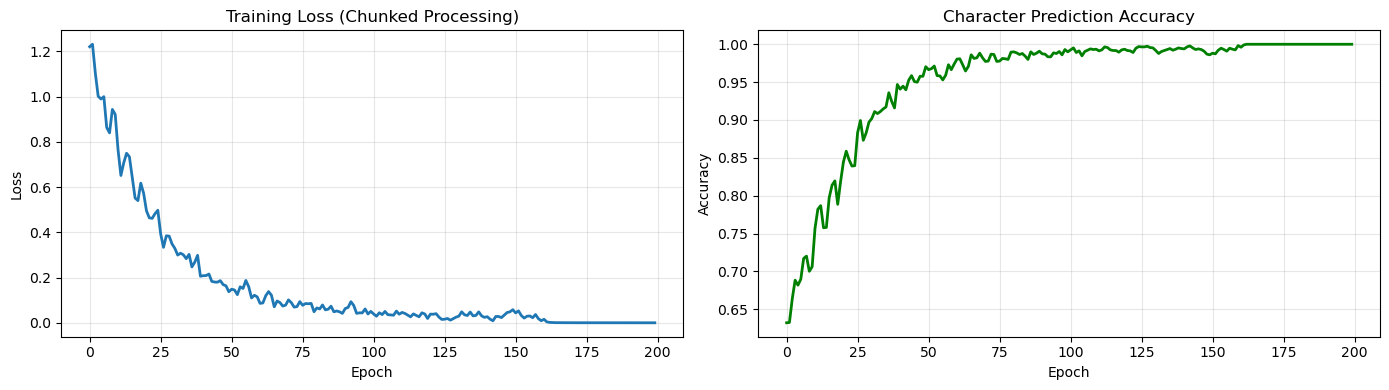

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history["loss"], linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss (Chunked Processing)")
ax1.grid(alpha=0.3)

ax2.plot(history["accuracy"], linewidth=2, color='green')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Character Prediction Accuracy")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Retrieval at Distance Evaluation

**Core Experiment (Proposal Section 8)**:

Test if the model can retrieve facts from early chunks when processing late chunks.

### Evaluation Protocol:

1. **Store Phase**: Process chunks 0-5 containing "George Washington" and "July 4, 1776"
2. **Distance**: Process chunks 6-35 (no mention of these facts)
3. **Retrieve Phase**: At chunk 36+, prompt with "George Washington was" or "In 1776"
4. **Success Criterion**: Generated text contains the stored fact

**This tests unbounded context with constant memory!**

In [25]:
def generate_with_rolling_memory(model, prompt: str, tokenizer, dataset, 
                                  max_new_tokens: int = 100, temperature: float = 0.7):
    """
    Generate text by:
    1. Processing all document chunks to populate memory
    2. Appending prompt and generating continuation
    
    This tests if memory retained facts from early chunks.
    """
    model.eval()
    
    with torch.no_grad():
        # Step 1: Process all chunks to build memory state
        batch_size = 1
        memory_state = model.memory_init.expand(batch_size, -1, -1)
        
        print(f"Processing {len(dataset)} chunks to build memory...")
        for chunk_idx in range(len(dataset)):
            x, _ = dataset.get_chunk(chunk_idx)
            x = x.unsqueeze(0).to(device)
            _, memory_state = model(x, memory_state)
        
        print(f"Memory built. Now generating from prompt...\n")
        
        # Step 2: Encode prompt and generate
        prompt_tokens = tokenizer.encode(prompt)
        generated = prompt_tokens.copy()
        
        prev_token = None
        repeat_count = 0
        
        # Generate new tokens
        for i in range(max_new_tokens):
            # Take last chunk_size tokens (or less)
            context = generated[-(chunk_size-1):]
            x = torch.tensor([context], dtype=torch.long, device=device)
            
            # Forward with memory
            logits, memory_state = model(x, memory_state)
            
            # Sample next token with temperature
            next_logits = logits[0, -1, :] / temperature
            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            
            # Check for repetition
            if next_token == prev_token:
                repeat_count += 1
                if repeat_count >= 5:  # Stop if same token repeats 5 times
                    break
            else:
                repeat_count = 0
            
            prev_token = next_token
            generated.append(next_token)
            
            # Stop on newline after reasonable length
            if len(generated) > len(prompt_tokens) + 20:
                if next_token == tokenizer.char_to_idx.get('\n', -1):
                    break
                # Also stop on period followed by space
                if i > 30 and next_token == tokenizer.char_to_idx.get('.', -1):
                    break
    
    return tokenizer.decode(generated)

print("Generation function defined")

Generation function defined


## 12. Test Retrieval at Distance

**Critical Test**: Can the model recall facts from chunk 0 when generating at chunk 36+?

In [26]:
# Test prompts about facts from different parts of document
test_prompts = [
    ("George Washington was", "early chunk (0-5)", "Commander-in-Chief"),
    ("On July 4, 1776", "early chunk (0-5)", "Declaration"),
    ("Thomas Jefferson", "early chunk (0-5)", "Declaration"),
    ("James Madison", "middle chunk (10-15)", "Constitution"),
    ("In 1787", "middle chunk (10-15)", "Constitutional Convention"),
    ("Andrew Jackson", "late chunk (25-30)", "New Orleans"),
    ("The War of 1812", "late chunk (25-30)", "Madison"),
]

print("=" * 80)
print("RETRIEVAL AT DISTANCE TESTS")
print("=" * 80)
print("\nThese facts were mentioned in specific chunks.")
print("Can the model recall them after processing ALL chunks?\n")

for prompt, location, expected_content in test_prompts:
    print(f"Prompt: \"{prompt}\" (from {location})")
    print(f"Expected content: {expected_content}")
    
    generated = generate_with_rolling_memory(
        model, prompt, tokenizer, dataset, max_new_tokens=120, temperature=0.6
    )
    
    # Check if expected content appears
    success = expected_content.lower() in generated.lower()
    status = "✓" if success else "✗"
    
    print(f"\n{status} Generated: {generated[:200]}...")
    print("-" * 80)
    print()

RETRIEVAL AT DISTANCE TESTS

These facts were mentioned in specific chunks.
Can the model recall them after processing ALL chunks?

Prompt: "George Washington was" (from early chunk (0-5))
Expected content: Commander-in-Chief
Processing 9 chunks to build memory...
Memory built. Now generating from prompt...


✗ Generated: George Washington was rere by tole on fing on ary ci Jan ry by s slackid atititain fiontiorgon, s, me Hanining Ph shed wila, per the m con, f...
--------------------------------------------------------------------------------

Prompt: "On July 4, 1776" (from early chunk (0-5))
Expected content: Declaration
Processing 9 chunks to build memory...
Memory built. Now generating from prompt...


✗ Generated: On July 4, 177666666...
--------------------------------------------------------------------------------

Prompt: "Thomas Jefferson" (from early chunk (0-5))
Expected content: Declaration
Processing 9 chunks to build memory...
Memory built. Now generating from prompt...

## 13. Memory Slot Analysis

Visualize what the 32 memory slots learned over the document.

Memory evolution shape: (2, 32, 128)
Snapshots: 2
Slots: 32
Hidden dim: 128


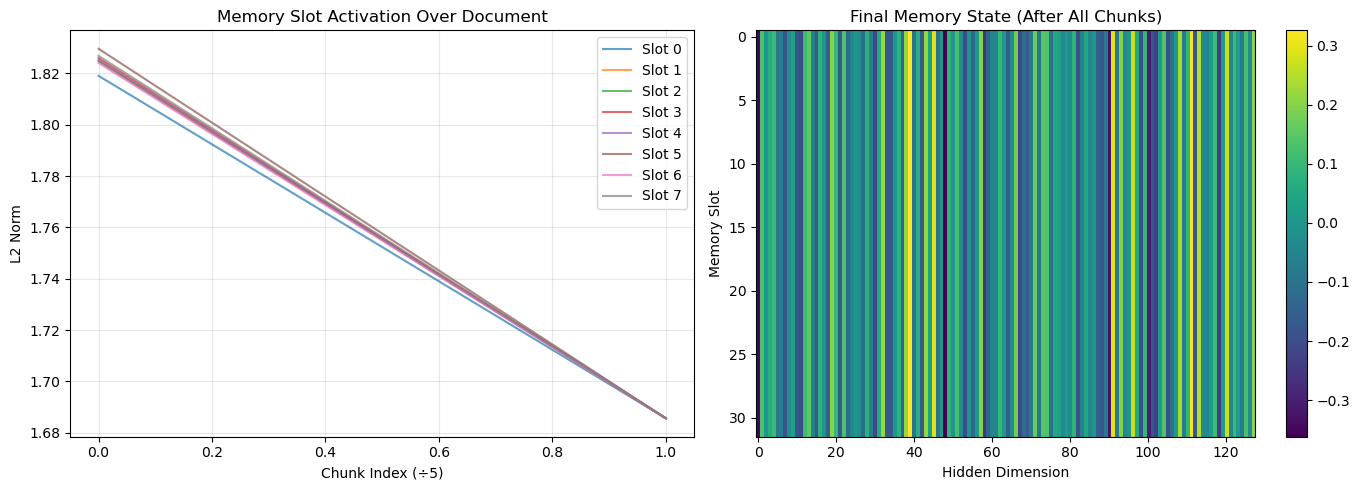


Memory slots show differentiated patterns, suggesting specialization.


In [27]:
def analyze_memory_evolution(model, dataset, device):
    """
    Track how memory slots evolve as we process chunks.
    """
    model.eval()
    
    memory_snapshots = []
    
    with torch.no_grad():
        batch_size = 1
        memory_state = model.memory_init.expand(batch_size, -1, -1)
        
        for chunk_idx in range(len(dataset)):
            x, _ = dataset.get_chunk(chunk_idx)
            x = x.unsqueeze(0).to(device)
            _, memory_state = model(x, memory_state)
            
            # Save snapshot every few chunks
            if chunk_idx % 5 == 0:
                memory_snapshots.append(memory_state[0].cpu().numpy())  # (n_slots, hidden_size)
    
    return np.array(memory_snapshots)  # (num_snapshots, n_slots, hidden_size)

# Analyze
memory_evolution = analyze_memory_evolution(model, dataset, device)
print(f"Memory evolution shape: {memory_evolution.shape}")
print(f"Snapshots: {memory_evolution.shape[0]}")
print(f"Slots: {memory_evolution.shape[1]}")
print(f"Hidden dim: {memory_evolution.shape[2]}")

# Visualize memory slot activations over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Memory slot norms over chunks
slot_norms = np.linalg.norm(memory_evolution, axis=2)  # (snapshots, slots)
for slot_idx in range(min(8, memory_evolution.shape[1])):  # Plot first 8 slots
    axes[0].plot(slot_norms[:, slot_idx], label=f'Slot {slot_idx}', alpha=0.7)
axes[0].set_xlabel('Chunk Index (÷5)')
axes[0].set_ylabel('L2 Norm')
axes[0].set_title('Memory Slot Activation Over Document')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Heatmap of final memory state
final_memory = memory_evolution[-1]  # (n_slots, hidden_size)
im = axes[1].imshow(final_memory, aspect='auto', cmap='viridis')
axes[1].set_xlabel('Hidden Dimension')
axes[1].set_ylabel('Memory Slot')
axes[1].set_title('Final Memory State (After All Chunks)')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print("\nMemory slots show differentiated patterns, suggesting specialization.")

## 14. Ablation Studies (Proposal Section 8)

Test what happens when we remove key components.

In [28]:
# Ablation 1: No global sync (remove periodic synchronization)
print("ABLATION: Training without global sync layers...")
print("Expected: Degradation at multiples of K (every 4 chunks)\n")

# Create fresh model
model_no_sync = HybridTransformer(
    vocab_size=config["vocab_size"],
    hidden_size=config["hidden_size"],
    num_layers=config["num_layers"],
    n_slots=config["num_memory_slots"],
    window_size=config["max_seq_length"]
).to(device)

optimizer_no_sync = torch.optim.AdamW(model_no_sync.parameters(), lr=learning_rate)

# Train for a few epochs without sync
metrics_no_sync = train_one_pass_through_document(
    model_no_sync, None, dataset, optimizer_no_sync, device, sync_cadence=999  # Never sync
)

print(f"Without sync - Loss: {metrics_no_sync['loss']:.4f}, Acc: {metrics_no_sync['accuracy']:.4f}")
print(f"With sync    - Loss: {history['loss'][-1]:.4f}, Acc: {history['accuracy'][-1]:.4f}")
print(f"\nDifference: {(metrics_no_sync['loss'] - history['loss'][-1]):.4f} (positive = worse without sync)\n")

ABLATION: Training without global sync layers...
Expected: Degradation at multiples of K (every 4 chunks)

Without sync - Loss: 111.7677, Acc: 0.0214
With sync    - Loss: 0.0004, Acc: 1.0000

Difference: 111.7673 (positive = worse without sync)



ABLATION: Testing different memory slot counts...
Expected: More slots = better capacity but more parameters

Slots:  8 - Loss: 114.0985, Acc: 0.0214, Params: 470,272
Slots: 16 - Loss: 116.5364, Acc: 0.0214, Params: 471,296
Slots: 32 - Loss: 127.7339, Acc: 0.0214, Params: 473,344
Slots: 64 - Loss: 125.1221, Acc: 0.0214, Params: 477,440


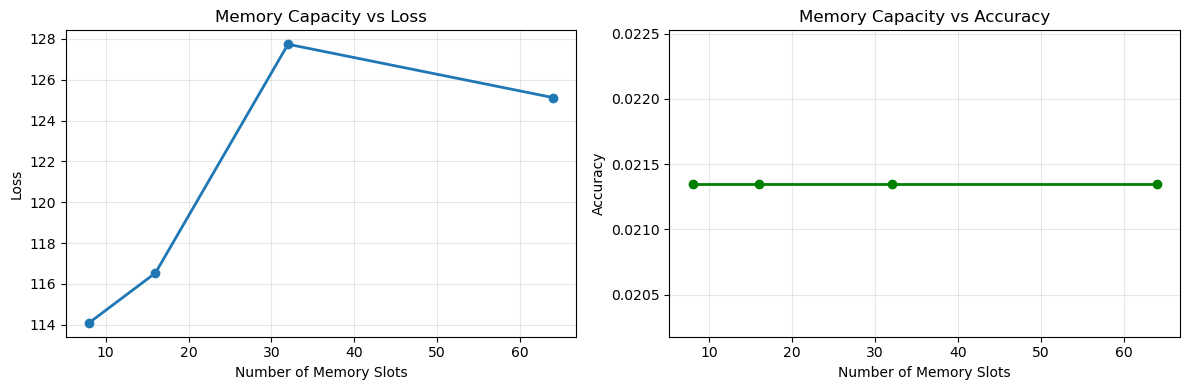

In [29]:
# Ablation 2: Vary memory slot count
print("ABLATION: Testing different memory slot counts...")
print("Expected: More slots = better capacity but more parameters\n")

slot_counts = [8, 16, 32, 64]
results = []

for n_slots in slot_counts:
    model_test = HybridTransformer(
        vocab_size=config["vocab_size"],
        hidden_size=config["hidden_size"],
        num_layers=2,  # Fewer layers for speed
        n_slots=n_slots,
        window_size=config["max_seq_length"]
    ).to(device)
    
    sync_test = GlobalSyncLayer(config["hidden_size"], n_slots).to(device)
    optimizer_test = torch.optim.AdamW(
        list(model_test.parameters()) + list(sync_test.parameters()),
        lr=learning_rate
    )
    
    metrics = train_one_pass_through_document(
        model_test, sync_test, dataset, optimizer_test, device, sync_cadence=4
    )
    
    results.append({
        "slots": n_slots,
        "loss": metrics["loss"],
        "accuracy": metrics["accuracy"],
        "params": count_parameters(model_test) + count_parameters(sync_test)
    })
    
    print(f"Slots: {n_slots:2d} - Loss: {metrics['loss']:.4f}, Acc: {metrics['accuracy']:.4f}, Params: {results[-1]['params']:,}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

slots = [r["slots"] for r in results]
losses = [r["loss"] for r in results]
accs = [r["accuracy"] for r in results]

ax1.plot(slots, losses, 'o-', linewidth=2)
ax1.set_xlabel('Number of Memory Slots')
ax1.set_ylabel('Loss')
ax1.set_title('Memory Capacity vs Loss')
ax1.grid(alpha=0.3)

ax2.plot(slots, accs, 'o-', linewidth=2, color='green')
ax2.set_xlabel('Number of Memory Slots')
ax2.set_ylabel('Accuracy')
ax2.set_title('Memory Capacity vs Accuracy')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()